# NN - LSTM Sequential Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
y_df = pd.read_csv("yieldcurves_v2.csv", parse_dates=['Date'])

In [3]:
sp_df = pd.read_csv("SPX_500_Data.csv",parse_dates=['Date'])

In [4]:
y_df.set_index("Date", inplace = True)
sp_df.set_index("Date", inplace = True)

In [5]:
y_df.shape

(8008, 10)

In [6]:
y_df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession
Date,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0


In [7]:
y_df.tail()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession
Date,,,,,,,,,,
2021-12-27,0.06,0.21,0.33,0.76,0.98,1.26,1.41,1.48,1.88,0
2021-12-28,0.06,0.20,0.39,0.74,0.99,1.27,1.41,1.49,1.90,0
2021-12-29,0.05,0.19,0.38,0.75,0.99,1.29,1.47,1.55,1.96,0
2021-12-30,0.05,0.19,0.38,0.73,0.98,1.27,1.44,1.52,1.93,0
2021-12-31,0.06,0.19,0.39,0.73,0.97,1.26,1.44,1.52,1.90,0


In [8]:
sp_df.head()

,Open,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,17.66,0,0.0000,0.0
1928-01-03,17.76,17.76,17.76,17.76,17.76,0,0.5631,0.0
1928-01-04,17.72,17.72,17.72,17.72,17.72,0,-0.2257,0.0
1928-01-05,17.55,17.55,17.55,17.55,17.55,0,-0.9687,0.0
1928-01-09,17.50,17.50,17.50,17.50,17.50,0,-0.2857,0.0


In [9]:
sp_df.tail()

,Open,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,
2021-09-13,4474.81,4492.99,4445.70,4468.73,4468.73,3096390000,0.2271,0.011
2021-09-14,4479.33,4485.68,4435.46,4443.05,4443.05,2568730000,-0.5780,0.011
2021-09-15,4447.49,4486.87,4438.37,4480.70,4480.70,3154760000,0.8403,0.011
2021-09-16,4477.09,4485.87,4443.80,4473.75,4473.75,3321030000,-0.1554,0.009
2021-09-17,4469.74,4471.52,4427.76,4432.99,4432.99,5622210000,-0.9195,0.010


In [10]:
y_df.isnull().sum()

3 Mo            4
6 Mo            1
1 Yr            1
2 Yr            1
3 Yr            1
5 Yr            1
7 Yr            1
10 Yr           1
30 Yr         995
Recession       0
dtype: int64

In [11]:
import datetime

def fill_nan_with_weekly_average(df):
  # Compute weekly averages

  monday = pd.Timestamp("1990-01-08")
  lastday = pd.Timestamp("2021-12-31")

  prev_avg = {}
  avg = {}
  while monday <= lastday:
    week = pd.date_range(monday, periods = 5, freq = "D")
    sub_df = df[week[0]:week[4]]

    for col in sub_df:
      avg[col] = sub_df[col].mean(skipna=True)
      if pd.isna(avg[col]):
        avg[col] = prev_avg[col]
      else:
        prev_avg[col] = avg[col]
      if sub_df[col].isnull().sum() != 0:
        for idx in week:
          try:
            if pd.isna(df[col].loc[idx]):
              df[col].loc[idx] = avg[col]
          except KeyError as e:
            # Must be a holiday
            pass
        
    monday = week[4] + datetime.timedelta(3
                                          )

fill_nan_with_weekly_average(y_df)

/var/folders/25/kxl7v5ls5mbflwc4p84qhy8m0000gn/T/ipykernel_5995/2442879773.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[idx] = avg[col]


In [12]:
y_df.isnull().sum()

3 Mo          0
6 Mo          0
1 Yr          0
2 Yr          0
3 Yr          0
5 Yr          0
7 Yr          0
10 Yr         0
30 Yr         0
Recession     0
dtype: int64

In [13]:
y_df["diff"] = y_df["10 Yr"] - y_df["2 Yr"]

In [14]:
y_df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff
Date,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0,0.07
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0,0.05
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0,0.06
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0,0.09
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0,0.12


In [15]:
df = pd.merge(y_df, sp_df, on = ["Date"])

In [16]:
df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,Open,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0,0.07,353.40,359.69,351.98,359.69,359.69,162070000,1.7487,0.021
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0,0.05,359.69,360.59,357.89,358.76,358.76,192330000,-0.2592,0.008
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0,0.06,358.76,358.76,352.89,355.67,355.67,177000000,-0.8688,0.017
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0,0.09,355.67,355.67,351.35,352.20,352.20,158530000,-0.9852,0.012
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0,0.12,352.20,354.24,350.54,353.79,353.79,140110000,0.4494,0.010


In [17]:
del df["Open"]

In [18]:
df.head()

,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,30 Yr,Recession,diff,High,Low,Close,Adj Close,Volume,% Gain/Loss (Close),% Price Variation
Date,,,,,,,,,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,8.00,0,0.07,359.69,351.98,359.69,359.69,162070000,1.7487,0.021
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,0,0.05,360.59,357.89,358.76,358.76,192330000,-0.2592,0.008
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,0,0.06,358.76,352.89,355.67,355.67,177000000,-0.8688,0.017
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,0,0.09,355.67,351.35,352.20,352.20,158530000,-0.9852,0.012
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,0,0.12,354.24,350.54,353.79,353.79,140110000,0.4494,0.010


# Split Data

In [19]:
y = df['Recession ']

X = df.drop(columns=['Recession '])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [21]:
X_scaler = StandardScaler().fit(X_train)

In [22]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_valid_scaled = X_scaler.transform(X)

In [23]:
def reshape_data(x):
    obj = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return obj

In [24]:
reshaped_X1_train_scaled = reshape_data(X_train_scaled)
reshaped_X1_test_scaled = reshape_data(X_test_scaled)
reshaped_X1_valid = reshape_data(X_valid_scaled)

# Build Model

In [25]:
model = Sequential()

2022-08-02 13:12:04.251427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
model.add(LSTM(128, input_shape=(reshaped_X1_train_scaled.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [27]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [28]:
model.fit(reshaped_X1_train_scaled, y_train, validation_split=0.1, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
179/179 - 9s - loss: 0.2722 - accuracy: 0.8985 - val_loss: 0.4237 - val_accuracy: 0.8927 - 9s/epoch - 53ms/step
Epoch 2/10
179/179 - 4s - loss: 0.1755 - accuracy: 0.9360 - val_loss: 0.6403 - val_accuracy: 0.7697 - 4s/epoch - 25ms/step
Epoch 3/10
179/179 - 5s - loss: 0.1448 - accuracy: 0.9441 - val_loss: 0.1662 - val_accuracy: 0.9448 - 5s/epoch - 25ms/step
Epoch 4/10
179/179 - 4s - loss: 0.1302 - accuracy: 0.9487 - val_loss: 0.1170 - val_accuracy: 0.9511 - 4s/epoch - 25ms/step
Epoch 5/10
179/179 - 5s - loss: 0.1260 - accuracy: 0.9499 - val_loss: 0.1014 - val_accuracy: 0.9653 - 5s/epoch - 25ms/step
Epoch 6/10
179/179 - 5s - loss: 0.1040 - accuracy: 0.9586 - val_loss: 0.1534 - val_accuracy: 0.9527 - 5s/epoch - 25ms/step
Epoch 7/10
179/179 - 5s - loss: 0.1040 - accuracy: 0.9595 - val_loss: 0.1344 - val_accuracy: 0.9495 - 5s/epoch - 26ms/step
Epoch 8/10
179/179 - 5s - loss: 0.1069 - accuracy: 0.9558 - val_loss: 0.0912 - val_accuracy: 0.9669 - 5s/epoch - 26ms/step
Epoch 9/10
179/1

In [29]:
loss, accuracy = model.evaluate(reshaped_X1_test_scaled, y_test, verbose=1)

50/50 [==============================] - 0s 9ms/step - loss: 0.0759 - accuracy: 0.9622


In [30]:
predictions1_class = model.predict(reshaped_X1_test_scaled)
classes = np.argmax(predictions1_class,axis=1)

50/50 [==============================] - 1s 8ms/step


In [31]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1421
           1       0.88      0.74      0.80       165

    accuracy                           0.96      1586
   macro avg       0.92      0.86      0.89      1586
weighted avg       0.96      0.96      0.96      1586



In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, classes)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1404   17]
 [  43  122]]

True Positives(TP) =  1404

True Negatives(TN) =  122

False Positives(FP) =  17

False Negatives(FN) =  43


<AxesSubplot:>

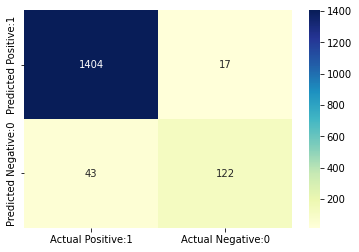

In [33]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predicted Positive:1', 'Predicted Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [35]:
history = model.fit(reshaped_X1_train_scaled, y_train, epochs = 10, batch_size=10)

Epoch 1/10
634/634 [==============================] - 11s 17ms/step - loss: 0.1542 - accuracy: 0.9405
Epoch 2/10
634/634 [==============================] - 11s 17ms/step - loss: 0.1377 - accuracy: 0.9465
Epoch 3/10
634/634 [==============================] - 11s 18ms/step - loss: 0.1158 - accuracy: 0.9538
Epoch 4/10
634/634 [==============================] - 12s 18ms/step - loss: 0.1159 - accuracy: 0.9524
Epoch 5/10
634/634 [==============================] - 12s 19ms/step - loss: 0.1135 - accuracy: 0.9538
Epoch 6/10
634/634 [==============================] - 11s 18ms/step - loss: 0.1109 - accuracy: 0.9557
Epoch 7/10
634/634 [==============================] - 12s 19ms/step - loss: 0.1002 - accuracy: 0.9582
Epoch 8/10
634/634 [==============================] - 12s 18ms/step - loss: 0.1076 - accuracy: 0.9593
Epoch 9/10
634/634 [==============================] - 12s 18ms/step - loss: 0.0899 - accuracy: 0.9640
Epoch 10/10
634/634 [==============================] - 12s 19ms/step - loss: 0.085

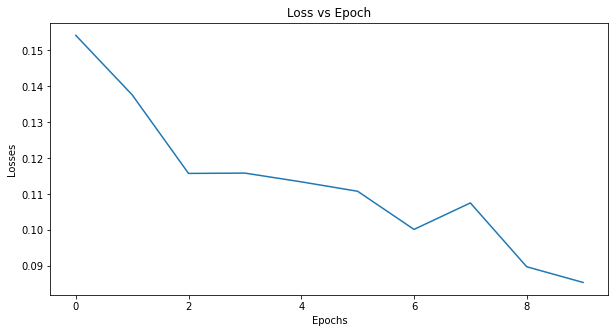

In [71]:
plt.figure(figsize =(10,5))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss vs Epoch")
plt.show()